todo
1. optimize hyperparameters
2. clean dataset
    - balance
3. data augmentation
4. add requirments.txt
5. correct title (of file as well)
6. go through all variable names
7. ask which types of groups should "be in focus". Do disabled people count?
8. more advaned duplicate dropping?
9. balancing the dataset needed?
10. dedicated train test split?
11. data augmentation only on train?
12. remove duplicates a second time
13. train test split after tokenization?
14. change train test split ratio?
15. wtf is "output_dim"?

# Hate Detection

In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score

from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


from random import sample

### Data Exploration

In [580]:
data = pd.read_csv('hate-text.csv')
data

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people
...,...,...,...,...
3896,3897,Gay people are all complete 4ssholes.,hateful,gay people
3897,3898,Black people are all complete 4ssholes.,hateful,black people
3898,3899,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,3900,Muslims are all complete 4ssholes.,hateful,Muslims


The dataset contains some missing values in the target_ident column, which we'll have to deal with later

In [581]:
# Using display() to display both at the same time. Won't comment any future use of display() (for obvious reasons)
display(
    data.isnull().any(),
    data[data.isna().any(axis=1)]
)

case_id         False
test_case       False
label_gold      False
target_ident     True
dtype: bool

,case_id,test_case,label_gold,target_ident
1271,1272,"Fucking hell, what a day.",non-hateful,NaN
1272,1273,That's a great fucking idea.,non-hateful,NaN
1273,1274,No fucking way.,non-hateful,NaN
1274,1275,I'm so fucking excited.,non-hateful,NaN
1275,1276,Are you fucking kidding me?,non-hateful,NaN
...,...,...,...,...
3097,3098,Pro lifers should get the fuck out of our coun...,non-hateful,NaN
3098,3099,Most gun dealers are seriously fucked in the h...,non-hateful,NaN
3099,3100,"By nature, corporate accountants are just shit...",non-hateful,NaN
3100,3101,Most real estate agents are absolute bastards.,non-hateful,NaN


No duplicate texts found

In [582]:
print(f'''duplicate texts: {data['test_case'].duplicated().any()}''')

duplicate texts: False


While the dataset is quite balanced in the target groups, it's still assymetric when it comes to the number of hate/non-hate texts

In [583]:
display(
    pd.DataFrame(data['label_gold'].value_counts()),
    pd.DataFrame(data['target_ident'].value_counts())
)

,count
label_gold,
hateful,2659
non-hateful,1242


,count
target_ident,
gay people,577
women,535
disabled people,510
Muslims,510
black people,504
trans people,485
immigrants,485


No unusually short/long texts

In [584]:
longest_text_length = data['test_case'].str.len().max()
shortest_text_length = data['test_case'].str.len().min()

longest_text_index = data['test_case'].str.len().idxmax()
shortest_text_index = data['test_case'].str.len().idxmin()

print(
    f'''Shortest: {longest_text_length}, "{data['test_case'][longest_text_index]}"\n'''
    f'''Longest: {shortest_text_length}, "{data['test_case'][shortest_text_index]}"'''
)

Shortest: 104, "When will it finally be clear to people that it's in a disabled person's nature to be an annoying prick?"
Longest: 11, "Ihate women"


### Data cleaning

Drop and rename columns to something more suitable

In [585]:
data = data.drop('case_id', axis=1)
data = data.rename(
    columns=
    {
        'test_case': 'text',
        'label_gold': 'label',
        'target_ident': 'target',
    }
)

data.head()

,text,label,target
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


It appears as though non of the missing target data have any relevant hate speech associated with them. This can easily be varified by manually looking at the dataset (given its tiny size). But alas, given my horrendous dyslexia i decided to programmatically varify it as a sanity check

In [586]:
target_search_words = [
    'gay',
    'women',
    'disabled',
    'Muslims',
    'black',
    'trans',
    'immigrants'
]

# Get all rows targets with NaNs
data_target_nans = data[data['target'].isna()]

for index, row in data_target_nans.iterrows():
    for word in target_search_words:
        # Split by words and search each one
        if word in row['text'].split(' '):
            print(f'''found target word in: "{row['text']}" row''')

I'm now confident in dropping all rows with target NaN values

In [587]:
data = data.dropna()

Balance the dataset

In [588]:
hateful = data['label'].value_counts()['hateful']
non_hateful = data['label'].value_counts()['non-hateful']

# Because we've got far more hateful texts
number_of_rows_to_drop = hateful - non_hateful

# randomly sample the rows and and drop them
rows_indexes_to_remove = data[data['label'] == 'hateful'].sample(n=number_of_rows_to_drop).index
data = data.drop(rows_indexes_to_remove)

display(
    pd.DataFrame(data['label'].value_counts()),
    pd.DataFrame(data['target'].value_counts())
)

,count
label,
hateful,947
non-hateful,947


,count
target,
gay people,330
black people,276
women,276
Muslims,258
disabled people,258
trans people,256
immigrants,240


### Data preprocessing

Shuffle the dataset

In [589]:
# Shuffles and returns the entire dataset as frac=1
data = data.sample(frac=1)

# Reset index after having both balanced and shuffled
data = data.reset_index(drop=True)
data

,text,label,target
0,This is the first time a trans person is nomin...,non-hateful,trans people
1,"Disabled lives might not be worth shit to you,...",non-hateful,disabled people
2,I really do believe immigrants are just lesser...,hateful,immigrants
3,We must not make Muslims suffer any more than ...,non-hateful,Muslims
4,We should test new drugs on trans people befor...,hateful,trans people
...,...,...,...
1889,"Statements like ""Muslims are scum"" are deeply ...",non-hateful,Muslims
1890,Trans people belong in a zoo.,hateful,trans people
1891,We should look up to these disabled people.,non-hateful,disabled people
1892,You are just a muzzie to me.,hateful,Muslims


In [590]:
print(
    f'''Shortest: {data['text'].str.len().min()}\n'''
    f'''Longest: {data['text'].str.len().max()}'''
)

Shortest: 14
Longest: 100


In [591]:
max_words_to_use = 1000

# Tokenize the text data (convert them into "sequences")
tokenizer = Tokenizer(num_words=max_words_to_use) # Consider only using the top 1000 words
tokenizer.fit_on_texts(data['text'])
tokenized_texts = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing (won't mention again)
for i in range(5):
    print(f'seq {i}: {tokenized_texts[i]}')

seq 0: [30, 18, 10, 282, 244, 4, 14, 22, 18, 313]
seq 1: [16, 38, 256, 17, 8, 55, 121, 3, 5, 33, 314, 70, 192, 283, 315]
seq 2: [6, 72, 54, 90, 24, 2, 26, 157, 100]
seq 3: [28, 62, 17, 59, 23, 137, 32, 122, 63, 35, 316, 2]
seq 4: [28, 27, 619, 481, 620, 91, 14, 1, 621, 622, 64, 91, 623]


The longest series of tokenized words is only 20 items. Thus, we'll set our padding length accordingly.

In [592]:
longest_tokenized_text = max(tokenized_texts, key=len)
print(f'longest sequence of tokenized text: {len(longest_tokenized_text)}')

longest sequence of tokenized text: 19


In [593]:
max_sequence_length = 20

# Pad the sequences to make them of uniform length
tokenized_padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length)

for i in range(5):
    print(f'seq {i}: {tokenized_padded_texts[i]}')

seq 0: [  0   0   0   0   0   0   0   0   0   0  30  18  10 282 244   4  14  22
  18 313]
seq 1: [  0   0   0   0   0  16  38 256  17   8  55 121   3   5  33 314  70 192
 283 315]
seq 2: [  0   0   0   0   0   0   0   0   0   0   0   6  72  54  90  24   2  26
 157 100]
seq 3: [  0   0   0   0   0   0   0   0  28  62  17  59  23 137  32 122  63  35
 316   2]
seq 4: [  0   0   0   0   0   0   0  28  27 619 481 620  91  14   1 621 622  64
  91 623]


In [594]:
# One-hot encode the labels
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])
onehot_encoded_targets = label_binarizer.fit_transform(data['target'])

print(f'labels: {onehot_encoded_labels[0]}')
print(f'targets: {onehot_encoded_targets[0]}\n')

for i in range(10):
    # the output looks identical for both
    print(f'label/target {i}: {onehot_encoded_labels[i][0]}')

labels: [1]
targets: [0 0 0 0 0 1 0]

label/target 0: 1
label/target 1: 1
label/target 2: 0
label/target 3: 1
label/target 4: 0
label/target 5: 0
label/target 6: 0
label/target 7: 0
label/target 8: 0
label/target 9: 1


In [595]:
train_texts, test_texts, train_labels, test_labels, train_targets, test_targets = train_test_split(
    tokenized_padded_texts,
    onehot_encoded_labels,
    onehot_encoded_targets,
    test_size=0.2
)

print(
    f'train_texts shape: {np.shape(train_texts)}\n'
    f'train_labels shape: {np.shape(train_labels)}\n'
    f'train_targets shape: {np.shape(train_targets)}\n'
    f'test_texts shape: {np.shape(test_texts)}\n'
    f'test_labels shape: {np.shape(test_labels)}\n'
    f'test_targets shape: {np.shape(test_targets)}'
)

train_texts shape: (1515, 20)
train_labels shape: (1515, 1)
train_targets shape: (1515, 7)
test_texts shape: (379, 20)
test_labels shape: (379, 1)
test_targets shape: (379, 7)


In [601]:
zippy = zip(
    ['label_model', 'target_model'],
    [1, 2],
    ['softmax', 'sigmoid']
)

for a, c, b in zippy:
    print(a)
    print(b)
    print(c)

label_model
softmax
1
target_model
sigmoid
2


In [620]:
models = {}

zippy = zip(
    ['label_model', 'target_model'],
    [train_labels, train_targets],
    ['sigmoid', 'softmax'],
    ['binary_crossentropy', 'categorical_crossentropy'],
)


for model_name, labels, activation_function, loss_function in zippy:
    model = Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        LSTM(units=32, activation='tanh'),
        
        # The number of neurons at the output depend on the number of classes we have
        # We get the number of classes by taking the shape of the label arrays as they're one-hot encoded
        Dense(labels.shape[1], activation=activation_function)
    ])

    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)

    # Will update the model objects inside the dictionary
    history = model.fit(train_texts, labels, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    
    models[model_name] = model
    models[model_name + '_history'] = history

Epoch 1/100
38/38 [==============================] - 5s 34ms/step - loss: 0.6816 - accuracy: 0.6254 - val_loss: 0.6528 - val_accuracy: 0.6832
Epoch 2/100
38/38 [==============================] - 1s 17ms/step - loss: 0.5697 - accuracy: 0.7483 - val_loss: 0.5150 - val_accuracy: 0.7558
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 0.3703 - accuracy: 0.8614 - val_loss: 0.3385 - val_accuracy: 0.8647
Epoch 4/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2081 - accuracy: 0.9208 - val_loss: 0.2601 - val_accuracy: 0.8845
Epoch 5/100
38/38 [==============================] - 1s 16ms/step - loss: 0.1185 - accuracy: 0.9670 - val_loss: 0.2205 - val_accuracy: 0.9274
Epoch 6/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0797 - accuracy: 0.9785 - val_loss: 0.2049 - val_accuracy: 0.9472
Epoch 7/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0535 - accuracy: 0.9884 - val_loss: 0.1983 - val_accuracy: 0.9505
Epoch 

In [621]:
models

{'label_model': <keras.engine.sequential.Sequential at 0x181759065b0>,
 'label_model_history': <keras.callbacks.History at 0x1817a7fdc10>,
 'target_model': <keras.engine.sequential.Sequential at 0x1817f601c10>,
 'target_model_history': <keras.callbacks.History at 0x1817f4ad880>}

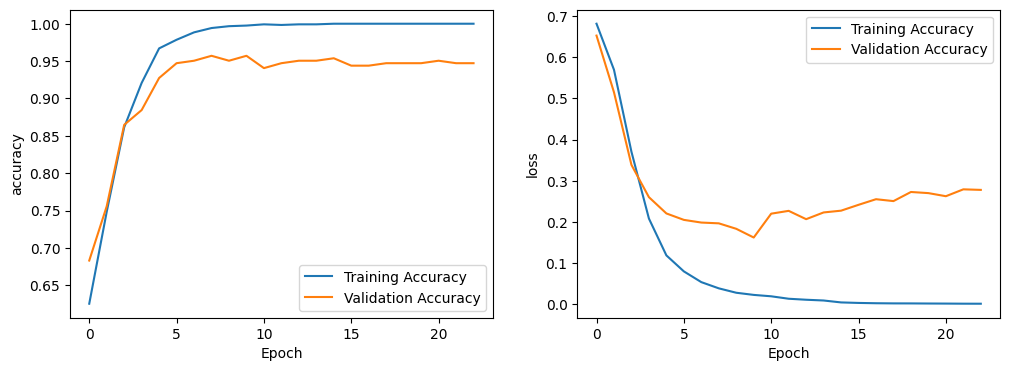

Accuracy: 96.0%
Loss: 0.12


In [622]:
test_model = models['label_model']
history = models['label_model_history']


test_loss, test_accuracy = test_model.evaluate(test_texts, test_labels, verbose=0)

plt.figure(figsize=(12, 4))

for subplot, metric in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, subplot)
    plt.plot(history.history[metric], label='Training Accuracy')
    plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)

In [ ]:
1 / 0

ZeroDivisionError: division by zero

# JUNK BELOW

In [ ]:
for (name, model), history in zip(models.items(), histories):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(history.history[metric], label='Training Accuracy')
        plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Sentiment analysis using an {name}')
    plt.show()

    print(
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}'    
    )

In [ ]:
for (name, model), history in zip(models.items(), histories):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(history.history[metric], label='Training Accuracy')
        plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Sentiment analysis using an {name}')
    plt.show()

    print(
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}'    
    )

In [ ]:
# Pretty straightforward code once you read it twice
for (name, model), history in zip(models.items(), histories):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test, verbose=0)
    
    # Argmax the predictions/labels in order to convert them into class labels
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)
    
    f1 = f1_score(actual_classes, predicted_classes, average='weighted')
    
    # Create confusion matrix
    cm = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(history.history[metric], label='Training Accuracy')
        plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Sentiment analysis using an {name} on train/val data')
    plt.show()

    print(
        f'Test accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Test loss: {round(test_loss, 2)}\n'
        f'Test F1: {f1}'
    )

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues', 
        xticklabels=np.unique(actual_classes),
        yticklabels=np.unique(actual_classes)
    )
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test data confusion matrix')
    plt.show()

{'label_model': <keras.engine.sequential.Sequential at 0x18155942040>,
 'label_model_history': <keras.callbacks.History at 0x1815d0bfb80>,
 'target_model': <keras.engine.sequential.Sequential at 0x18155b4d490>,
 'target_model_history': <keras.callbacks.History at 0x1815d0f4d60>}